In [1]:
from multisensory import *
import numba
from joblib import Parallel, delayed
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import bisect

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

plt.style.use("./style_sheet.mplstyle")

col = ["xkcd:muted blue", "xkcd:coral pink"]

In [2]:
def trials(num_channels, num_classes, pe, pc, time_steps=90, repeats=10000):
    M = np.random.randint(num_classes, size=repeats)
    E = choice(np.arange(2), p=[1-pe, pe], size=(repeats, time_steps))
    E[M==0, :] = 0
    # use this when E=0
    C0 = np.random.randint(num_classes, size=(repeats, time_steps, num_channels))
    # use this when E=1, initially set up so that correct answer is 0, then shift by M
    p = np.ones(num_classes)*(1-pc)/(num_classes-1)
    p[0] = pc
    C1 = choice(np.arange(num_classes), size=(repeats, time_steps, num_channels), p=p)
    C1 = (C1+M[:, None, None]) % num_classes
    C = C1*E[:, :, None]+C0*(1-E[:, :, None])
    return M, E, C

@numba.jit(nopython=True)
def count_fta(C, num_classes):
    repeats, time_steps, num_channels = C.shape
    num_features = (num_channels+1)*num_classes
    outcount = np.zeros((repeats, num_features), dtype=np.int64)
    curcount = np.zeros(num_classes, dtype=np.int64)
    for r in range(repeats):
        for t in range(time_steps):
            curcount[:] = 0
            for c in range(num_channels):
                curcount[C[r, t, c]] += 1
            for cls in range(num_classes):
                f = cls*(num_channels+1)+curcount[cls]
                outcount[r, f] += 1
    return outcount

@numba.jit(nopython=True)
def count_atf(C, num_classes):
    repeats, time_steps, num_channels = C.shape
    outcount = np.zeros((repeats, num_classes), dtype=np.int64)
    for r in range(repeats):
        for t in range(time_steps):
            for c in range(num_channels):
                outcount[r, C[r, t, c]] += 1
    return outcount

def count(C, num_classes, fta=True):
    if fta:
        return count_fta(C, num_classes)
    else:
        return count_atf(C, num_classes)

def dataset(num_channels, num_classes, pe, pc, time_steps=90, repeats=10000, fta=True):
    M, E, C = trials(num_channels, num_classes, pe, pc, time_steps, repeats)
    C = count(C, num_classes, fta=fta)
    return M, C

def sim_acc(num_channels, num_classes, pe, pc, time_steps=90, repeats=10000, fta=True):
    M_train, C_train = dataset(num_channels, num_classes, pe, pc, time_steps, repeats, fta)
    model = make_pipeline(StandardScaler(), linear_model.LogisticRegression())
    model.fit(C_train, M_train)
    M_test, C_test = dataset(num_channels, num_classes, pe, pc, time_steps, repeats, fta)
    return model.score(C_test, M_test)

# # sim_acc(2, 10, 0.1, 0.95)
# pc_range = np.linspace(1/3, 1, 10)
# pe_range = np.linspace(0, 1/3, 8)
# PC, PE = np.meshgrid(pc_range, pe_range)

# acc = {}
# all_num_channels = [2, 5]
# all_num_classes = [3, 6]
# thekeys = []
# thejob = []
# f = delayed(np.vectorize(sim_acc))
# for i, num_channels in enumerate(all_num_channels):
#     for j, num_classes in enumerate(all_num_classes):
#         for fta in [False, True]:
#             num_features = (num_channels+1)*num_classes
#             key = (num_channels, num_classes, fta)
#             thekeys.append(key)
#             thejob.append(f(num_channels, num_classes, PE, PC, time_steps=50, repeats=10000//6*num_features, fta=fta))
# theresults = Parallel(n_jobs=-1)(thejob)
# for (num_channels, num_classes, fta), A in zip(thekeys, theresults):
#     acc[num_channels, num_classes, fta] = A

In [3]:
# maxdiff = max((acc[ch, cl, fta]-acc[ch, cl, not fta]).max() for ch, cl, fta in acc.keys())
# print(maxdiff)
# plt.figure(figsize=(9, 9))
# for i, num_channels in enumerate(all_num_channels):
#     for j, num_classes in enumerate(all_num_classes):
#         plt.subplot(2, 2, 2*i+j+1)
#         # A = acc[num_channels, num_classes, False]
#         # A = acc[num_channels, num_classes, True]
#         A = acc[num_channels, num_classes, True]-acc[num_channels, num_classes, False]
#         # A = acc[num_channels, num_classes, True]/acc[num_channels, num_classes, False]
#         plt.imshow(A, origin='lower',
#                 # vmin=0, vmax=1,
#                 vmin=0, vmax=maxdiff,
#                 cmap='plasma',
#                 extent=image_extent_from_linear_range(pc_range)+image_extent_from_linear_range(pe_range),
#                 aspect='auto')
#         plt.xlabel('pc')
#         plt.ylabel('pe')
#         plt.title(f'{num_channels=}, {num_classes=}')
#         # plt.colorbar()
# plt.tight_layout()

In [4]:
# num_channels = 5
# num_classes = 6
# A_fta = acc[num_channels, num_classes, True]
# A_atf = acc[num_channels, num_classes, False]
# A = A_fta-A_atf
# A = A_fta

# plt.figure(figsize=(12, 4))
# plt.subplot(131)
# plt.imshow(A,
#            origin='lower',
#            vmin=0, vmax=1,
#            cmap='plasma',
#            extent=image_extent_from_linear_range(pc_range)+image_extent_from_linear_range(pe_range),
#            aspect='auto')

# plt.subplot(132)
# extended_pe_range = np.linspace(np.amin(pe_range), np.amax(pe_range), 50)
# extended_pc_range = np.linspace(np.amin(pc_range), np.amax(pc_range), 51)
# extended_PC, extended_PE = np.meshgrid(extended_pc_range, extended_pe_range)

# def interpolated_A(A):
#    finterp = RectBivariateSpline(pe_range, pc_range, A)
#    extended_A = finterp(extended_pe_range, extended_pc_range)
#    return finterp, extended_A

# finterp, extended_A = interpolated_A(A)

# plt.imshow(extended_A,
#            origin='lower',
#            vmin=0, vmax=1,
#            cmap='plasma',
#            extent=image_extent_from_linear_range(extended_pc_range)+image_extent_from_linear_range(extended_pe_range),
#            aspect='auto')

# # cs = plt.contour(extended_PC, extended_PE, extended_A, colors='black', linestyles='dashed')
# # plt.clabel(cs, colors='k', inline=True, fmt='%.2f')

# plt.subplot(133)

# ref_acc = 0.8
# finterp_diff, extended_A_diff = interpolated_A(A_fta-A_atf)
# finterp_fta, extended_A_fta = interpolated_A(A_fta)
# finterp_atf, extended_A_atf = interpolated_A(A_atf)

# all_atf = []
# for pe in extended_pe_range:
#    try:
#       # find the value of pc that gives fta = ref_acc
#       f = lambda pc: finterp_fta(pe, pc)-ref_acc
#       pc = bisect(f, np.amin(pc_range), np.amax(pc_range))
#       all_atf.append(finterp_atf(pe, pc, grid=False))
#       # diffs.append(finterp_fta(pe, pc, grid=False)-finterp_atf(pe, pc, grid=False))
#    except ValueError:
#       # diffs.append(np.nan)
#       all_atf.append(np.nan)

# plt.axhline(ref_acc, ls='--', c='C0', label='FtA')   
# plt.axhline(1/num_classes, ls='--', c='k', label='Chance')
# plt.plot(extended_pe_range, all_atf, c='C1', label='AtF')
# plt.xlabel('pe')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')

# plt.tight_layout()


In [5]:
# ref_acc = 0.8

# extended_pe_range = np.linspace(np.amin(pe_range), np.amax(pe_range), 50)
# extended_pc_range = np.linspace(np.amin(pc_range), np.amax(pc_range), 51)

# # plt.figure(figsize=(9, 9))
# for i, num_channels in enumerate(all_num_channels):
#     for j, num_classes in enumerate(all_num_classes):
#         # plt.subplot(2, 2, 2*i+j+1)
#         A_fta = acc[num_channels, num_classes, True]
#         A_atf = acc[num_channels, num_classes, False]
#         finterp_fta = RectBivariateSpline(pe_range, pc_range, A_fta)
#         finterp_atf = RectBivariateSpline(pe_range, pc_range, A_atf)
#         all_atf = []
#         for pe in extended_pe_range:
#             try:
#                 # find the value of pc that gives fta = ref_acc
#                 f = lambda pc: finterp_fta(pe, pc)-ref_acc
#                 pc = bisect(f, np.amin(pc_range), np.amax(pc_range))
#                 all_atf.append(finterp_atf(pe, pc, grid=False))
#             except ValueError:
#                 all_atf.append(np.nan)

#         # plt.axhline(ref_acc, ls='--', c='C0', label='FtA')   
#         # plt.axhline(1/num_classes, ls='--', c='k', label='Chance')
#         plt.plot(extended_pe_range, all_atf, label=f'ATF {num_classes=} {num_channels=}')

# plt.xlabel('pe')
# plt.ylabel('Accuracy')
# plt.axhline(ref_acc, ls='--', c='k', label='FtA')   
# plt.legend(loc='best')

# plt.tight_layout()


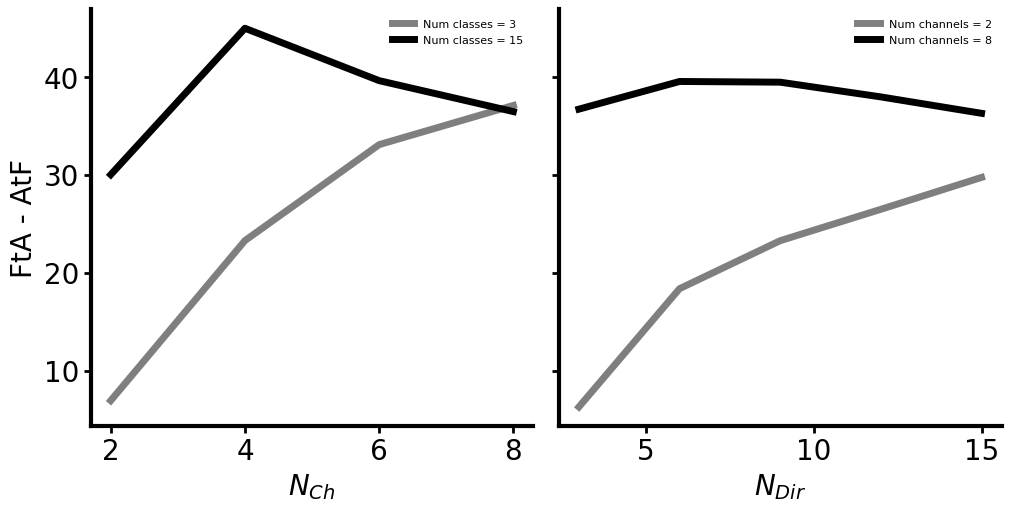

In [6]:
# N_Ch, N_Dir
def channel_class_map(num_chan, num_class, time_steps=90, repeats_base=10000):
    acc = {}
    thekeys = []
    thejob = []
    pc_range = np.linspace(0.9, 1, 3)
    pe_range = np.linspace(0.01, 0.05, 5)
    PC, PE = np.meshgrid(pc_range, pe_range)
    f = delayed(np.vectorize(sim_acc))
    for num_channels, num_classes in np.broadcast(num_chan, num_class):
        for fta in [False, True]:
            num_features = (num_channels+1)*num_classes
            key = (num_channels, num_classes, fta)
            thekeys.append(key)
            thejob.append(f(num_channels, num_classes, PE, PC, time_steps=time_steps, repeats=repeats_base//6*num_features, fta=fta))
    theresults = Parallel(n_jobs=-1)(thejob)
    for (num_channels, num_classes, fta), A in zip(thekeys, theresults):
        acc[num_channels, num_classes, fta] = A
    b = np.broadcast(num_chan, num_class)
    maxdiffs = [np.amax(acc[nch, ncl, True]-acc[nch, ncl, False]) for nch, ncl in b]
    return maxdiffs

num_channels_range = np.arange(2, 8+1, 2)
num_classes_range = np.arange(3, 15+1, 3)
alphas = [0.5, 1.0]

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=False, sharey=True, constrained_layout=True)
plt.sca(ax[0])
for a, ncl in enumerate([np.amin(num_classes_range), np.amax(num_classes_range)]):
    plt.plot(num_channels_range, np.array(channel_class_map(num_channels_range, ncl))*100, c='k', linewidth=5, alpha=alphas[a], label=f'Num classes = {ncl}')
plt.xlabel('$N_{Ch}$')
plt.ylabel('FtA - AtF')
plt.legend(loc='best')

plt.sca(ax[1])
for a, nch in enumerate([np.amin(num_channels_range), np.amax(num_channels_range)]):
    plt.plot(num_classes_range, np.array(channel_class_map(nch, num_classes_range))*100, c='k', linewidth=5, alpha=alphas[a], label=f'Num channels = {nch}')
plt.xlabel('$N_{Dir}$')
plt.legend(loc='best')
plt.savefig('multidim_0.svg')

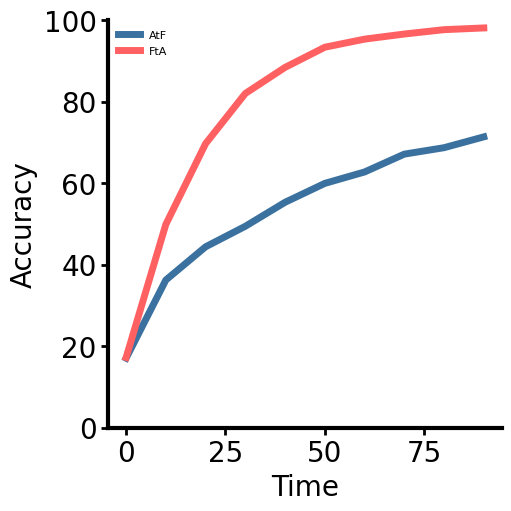

In [7]:
# Sparse
num_channels = 5
num_classes = 6
pc = 1.0
pe = 0.05
all_time_steps = np.arange(0, 90+1, 10)

all_acc = defaultdict(list)
for time_steps in all_time_steps:
    for fta in [False, True]:
        A = np.vectorize(sim_acc)(num_channels, num_classes, pe, pc,
                                time_steps=time_steps, repeats=10000,
                                fta=fta)
        all_acc[fta].append(A * 100)

plt.subplots(constrained_layout=True)
plt.plot(all_time_steps, all_acc[False], c=col[0], linewidth=5, label='AtF')
plt.plot(all_time_steps, all_acc[True], c=col[1], linewidth=5, label='FtA')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
(np.array(all_acc[True])-np.array(all_acc[False])).max()
plt.savefig('multidim_1.svg')

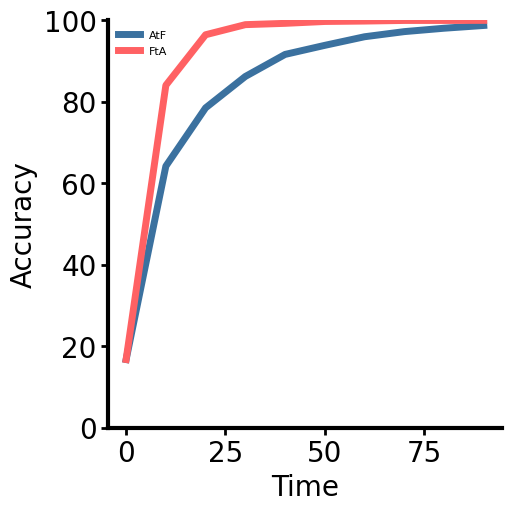

In [8]:
# Dense
num_channels = 5
num_classes = 6
pc = 1.0
pe = 0.15
all_time_steps = np.arange(0, 90+1, 10)

all_acc = defaultdict(list)
for time_steps in all_time_steps:
    for fta in [False, True]:
        A = np.vectorize(sim_acc)(num_channels, num_classes, pe, pc,
                                time_steps=time_steps, repeats=10000,
                                fta=fta)
        all_acc[fta].append(A * 100)

plt.subplots(constrained_layout=True)
plt.plot(all_time_steps, all_acc[False], c=col[0], linewidth=5, label='AtF')
plt.plot(all_time_steps, all_acc[True], c=col[1], linewidth=5, label='FtA')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
(np.array(all_acc[True])-np.array(all_acc[False])).max()
plt.savefig('multidim_2.svg')

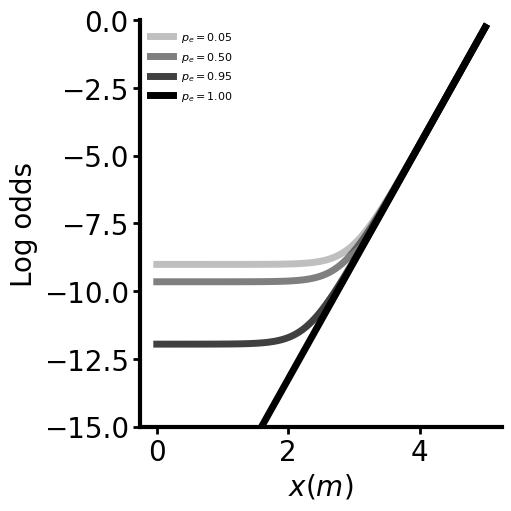

In [9]:
# Log-odds
pc = 0.95
num_channels = 5
num_classes = 6
x = np.linspace(0, num_channels, 100)
pe_values = [0.05, 0.5, 0.95, 1.0]
plt.subplots(constrained_layout=True)
for av, pe in enumerate(pe_values):
    a = (1/num_classes)**num_channels*(1-pe)
    pi = (1-pc)/(num_channels-1)
    b = pi**num_channels
    c = pc/pi
    av = (av + 1) / len(pe_values)
    plt.plot(x, np.log(a+b*c**x), c='k', linewidth=5, alpha=av, label=f'$p_e={pe:.2f}$')
plt.legend(loc='best')
plt.xlabel('$x(m)$')
plt.ylim([-15, 0])
plt.ylabel('Log odds')
plt.savefig('multidim_3.svg')